<a href="https://colab.research.google.com/github/kranti-experiments/EVA4/blob/master/S11/S11_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
if(torch.cuda.is_available):
    device = 'cuda'
else:
    device = 'cpu'

In [4]:
from AlbumentationTransforms import AlbumentationTransform
from dataloader import getDataLoader

import albumentations as AL
import albumentations.pytorch as AT
import cv2

train_transform = AlbumentationTransform([
                                       AL.PadIfNeeded(min_height=40, min_width=40, border_mode=cv2.BORDER_REFLECT_101, p=0.5),
                                       AL.RandomCrop(32, 32),
                                       AL.Flip(p=0.5),
                                       AL.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                                       AL.Cutout(num_holes=1, max_h_size=8, max_w_size = 8, p=1),
                                       AT.ToTensor()
                                       ])
# Test Phase transformations
test_transform = AlbumentationTransform([AL.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), AT.ToTensor()])

In [5]:
trainloader, testloader = getDataLoader('CIFAR10', 512, train_transform, test_transform)

Extracting ../data/cifar-10-python.tar.gz to ../data


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

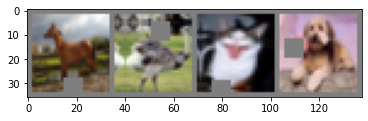

horse  bird   cat   dog


In [8]:
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
from models import CustomResNet

net = CustomResNet.CustomResNet()
net = net.to(device)

summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [12]:
from LRfinder import LRFinder
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

  pip install torch-lr-finder -v --global-option="amp"


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


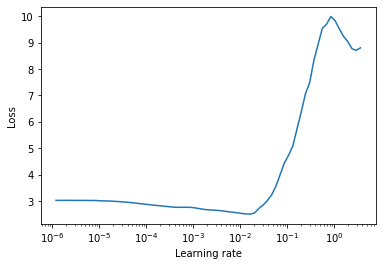

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-7,  momentum = 0.9)#weight_decay=1e-2)
lr_finder = LRFinder(net, optimizer, criterion, device)
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)#, step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [19]:
loss = lr_finder.history['loss']
lr = lr_finder.history['lr']
print(min(loss))
print(lr[loss.index(min(loss))])

2.5041557705096262
0.01659586907437559


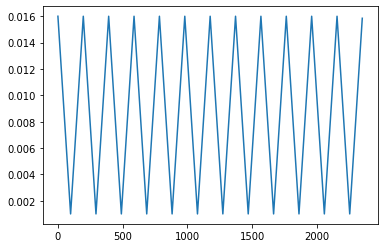

In [20]:
import plot_cyclic_lr

num_iterations = 98*24 #Batch_size = 512, 98 iterations in 1 epoch for CIFAR-10 dataset, 24 Epochs
stepsize = 98 #Iterations in 1 epoch
max_lr = 0.016 #best_lr from above
min_lr = 0.001 #1/10th of max_lr

plot_cyclic_lr.plot_lr(num_iterations, stepsize, max_lr, min_lr)

In [21]:
from torch.optim.lr_scheduler import StepLR

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.95, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                 max_lr=0.016,
                 epochs=24,
                 steps_per_epoch=len(trainloader),                               
                 pct_start=0.5,
                 div_factor=10,
                 final_div_factor=1e4)

In [22]:
import train

net = train.cifar10train(net, device, trainloader, optimizer, criterion, 24, scheduler)

[1,    10] loss: 2.544
[1,    20] loss: 2.111
[1,    30] loss: 1.851
[1,    40] loss: 1.694
[1,    50] loss: 1.615
[1,    60] loss: 1.525
[1,    70] loss: 1.477
[1,    80] loss: 1.452
[1,    90] loss: 1.428
[2,    10] loss: 1.333
[2,    20] loss: 1.322
[2,    30] loss: 1.291
[2,    40] loss: 1.311
[2,    50] loss: 1.275
[2,    60] loss: 1.250
[2,    70] loss: 1.222
[2,    80] loss: 1.173
[2,    90] loss: 1.159
[3,    10] loss: 1.130
[3,    20] loss: 1.116
[3,    30] loss: 1.140
[3,    40] loss: 1.116
[3,    50] loss: 1.111
[3,    60] loss: 1.077
[3,    70] loss: 1.018
[3,    80] loss: 1.017
[3,    90] loss: 1.031
[4,    10] loss: 1.009
[4,    20] loss: 0.981
[4,    30] loss: 0.980
[4,    40] loss: 0.999
[4,    50] loss: 0.966
[4,    60] loss: 1.007
[4,    70] loss: 0.965
[4,    80] loss: 0.955
[4,    90] loss: 0.965
[5,    10] loss: 0.949
[5,    20] loss: 0.930
[5,    30] loss: 0.879
[5,    40] loss: 0.872
[5,    50] loss: 0.862
[5,    60] loss: 0.856
[5,    70] loss: 0.884
[5,    80] 

In [23]:
import test

test.cifar10test(net, testloader, device)

Accuracy of the network on the 10000 test images: 89 %


In [24]:
from torch.optim.lr_scheduler import StepLR
import oncecycle


epochs = 24
batchsize = 512


onecycle = oncecycle.OneCycle(int(len(trainloader) * epochs /batchsize), 0.016, prcnt=( 5) * 100/epochs, momentum_vals=(0.95, 0.8))

In [25]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.95, weight_decay=1e-4)


In [26]:
import train

net = train.cifar10train(net, device, trainloader, optimizer, criterion, 24, scheduler=None, use_cycle=True, send_cycle=onecycle)

[1,    10] loss: 1.014
[1,    20] loss: 7.380
[1,    30] loss: 5.447
[1,    40] loss: 5.310
[1,    50] loss: 2.000
[1,    60] loss: 0.857
[1,    70] loss: 0.891
[1,    80] loss: 1.051
[1,    90] loss: 0.608
[2,    10] loss: 0.772
[2,    20] loss: 2.075
[2,    30] loss: 0.599
[2,    40] loss: 0.530
[2,    50] loss: 0.653
[2,    60] loss: 0.747
[2,    70] loss: 0.675
[2,    80] loss: 1.176
[2,    90] loss: 1.377
[3,    10] loss: 1.064
[3,    20] loss: 0.542
[3,    30] loss: 0.618
[3,    40] loss: 0.458
[3,    50] loss: 0.539
[3,    60] loss: 0.488
[3,    70] loss: 0.429
[3,    80] loss: 0.525
[3,    90] loss: 0.545
[4,    10] loss: 0.493
[4,    20] loss: 1.010
[4,    30] loss: 0.734
[4,    40] loss: 0.394
[4,    50] loss: 0.347
[4,    60] loss: 0.420
[4,    70] loss: 0.457
[4,    80] loss: 0.516
[4,    90] loss: 0.395
[5,    10] loss: 0.406
[5,    20] loss: 0.518
[5,    30] loss: 0.403
[5,    40] loss: 0.363
[5,    50] loss: 0.699
[5,    60] loss: 0.832
[5,    70] loss: 0.477
[5,    80] 

In [27]:
import test

test.cifar10test(net, testloader, device)

Accuracy of the network on the 10000 test images: 88 %
